#### Imports, check that GPU is used

In [1]:
! nvcc  --version
! pip install tensorflow keras --quiet
! pip install keras-tuner --quiet
! pip install keras-applications
! pip install seaborn --quiet
! pip install kaggle --quiet

! pip install pyyaml h5py --quiet  # Required to save models in HDF5 format

# needed for AugMix (removed)
# !pip install keras-cv --quiet

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [2]:
# dataset
import shutil
import os

import pandas as pd
import collections

# model
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.applications import MobileNetV2

import keras_tuner as kt
# from keras_cv.layers import AugMix

# graphs/stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

2025-05-21 10:02:15.665766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747821735.679713   42916 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747821735.684289   42916 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747821735.696433   42916 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747821735.696444   42916 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747821735.696447   42916 computation_placer.cc:177] computation placer alr

In [3]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
#assert 'GPU' in str(device_lib.list_local_devices())
#assert len(tf.config.list_physical_devices('GPU')) > 0

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Dataset preparation

The dataset contains 2 folders
*   Infected
*   Parasitized
And a total of 27,558 images.
Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/
And uploaded here, so anybody trying to start working with this dataset can get started immediately, as to download the
dataset from NIH website is quite slow.

1. load and split the dataset in train/val (80/20) & getting label names
2. compute dataset statistics
3. dataset standardization
4. dataset augmentation

#### Loading, splitting, standardizing the dataset and getting class names

In [4]:
# dataset folder
directory = "./cell_images"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

# Concatenate data paths with labels
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1)

In [5]:
# splitting the dataset and getting class names
img_height = 128 # UPDATED FOR MOBILENET
img_width = 128 # UPDATED FOR MOBILENET
batch_size = 32
SEED = 123 # for reproducibility

# training, test set split
# resizing already handled by TensorFlow
# no need to reshape

print('Loading and splitting the tf_dataset')
train_set, test_set = keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,  # 80/20%
  subset="both",
  # shuffle=False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary'    # parasitized/uninfected
)

Loading and splitting the tf_dataset
Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Using 5511 files for validation.


I0000 00:00:1747821741.650499   42916 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


In [6]:
# getting the class names
classes = train_set.class_names
num_classes = len(classes)
print(f'[0={classes[0]}, 1={classes[1]}]')

[0=Parasitized, 1=Uninfected]


#### Data augmentation (custom pipeline)

We will now extend (double) the training dataset by adding images obtained with various data augmentation techniques. The augmented dataset is merged with the training set to enalrge it. At last, the merged dataset is normalized.

In [7]:

# we have discovered that AugMix, which has great theoretical performances does not work well
# on our medical images as it introduces too many color variations, so we moved to a more
# conventional data augmentation pipeline
# AugMix(
#         severity=1,
#         chain_depth=1,
#         alpha=0.1,
#         value_range=(0, 255),
#     ),
# see https://arxiv.org/abs/1912.02781 for details on AugMix

preprocessing = keras.Sequential([
    # geometric transformations
    layers.RandomRotation(factor=0.2),
    layers.RandomFlip(mode='horizontal_and_vertical'),

    # illumination transformations
    layers.RandomBrightness(factor=0.15),
    layers.RandomContrast(factor=0.15),

    # some noise
    layers.GaussianNoise(stddev=0.05),
    #layers.Rescaling(1./255), # data standardization
])

augmented_dataset = train_set.map(lambda x, y: (preprocessing(x), y))
# concatenate the two datasets to form a big one
train_set = train_set.concatenate(augmented_dataset)

print('Augmented train set size:', augmented_dataset.cardinality().numpy()*batch_size)
print('Merged train set size:', train_set.cardinality().numpy()*batch_size)

Augmented train set size: 22048
Merged train set size: 44096


Do not rerun this cell on its own otherwise the dataset doubles each time

Now we standardize the training set as well as the merged dataset

In [8]:
train_set = train_set.map(lambda x, y: (x/255, y))

for image, _ in train_set.take(5):
    img = image.numpy()
    print("Image shape:", img.shape)
    print("Pixel value range: min =", img.min(), ", max =", img.max())

Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9254174
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9368056
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.91381645
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9336079
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.93119043


2025-05-21 10:02:23.368351: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The images are preprocessed and standardized

/tmp/ipykernel_42916/2243483184.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(labels[i].numpy())], fontsize=6)
2025-05-21 10:02:23.753765: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


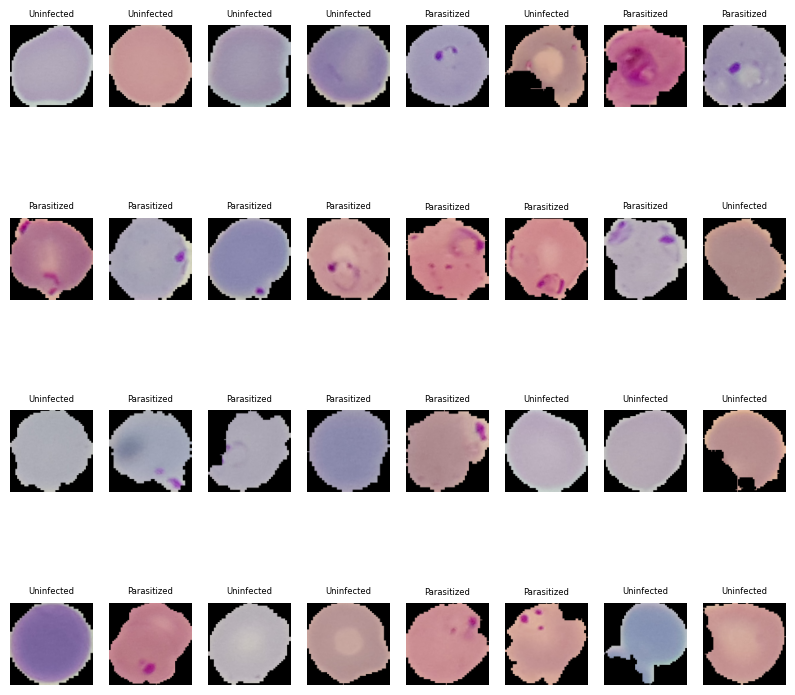

In [9]:
plt.figure(figsize=(10, 10))

for images, labels in train_set.take(1):
    num_images = batch_size  # Show more images
    for i in range(num_images):
        ax = plt.subplot(4, 8, i+1)  # 4x8 grid
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[int(labels[i].numpy())], fontsize=6)
        plt.axis("off")

plt.subplots_adjust(hspace=0)
plt.show()


As you can see the images are changed

### Transfer learning using MobileNetV2 & KerasTuner

1. Build the model replacing the top layers of MobileNetV2 with custom ones
2. Use KerasTuner to select the best number of neurons 
3. Retrain the model on the entire train_set
4. Evaluate the model's performance

In [10]:
def model_builder(hp):
    input_shape = (128, 128, 3) # Height, Width, Channels (RGB)
    mobile_net = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    mobile_net.trainable = False

    model = keras.Sequential()
    model.add(mobile_net) # add MobileNetV2 to base model

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(
        layers.Dense(
            units=hp.Int('units_1', min_value=64, max_value=512, step=64), 
            activation='relu'
        )
    )
        # tune dropout rate 
    model.add(
        layers.Dropout(
            rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.05)
        )
    )

    #""" num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    #for i in range(num_layers):
    #    model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32), activation='relu'))
    #    model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1))) """

    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    # tune the optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    lrate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG')

    # defaults to adam
    optimizer = keras.optimizers.Adam()
    match optimizer_choice:
        case 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=lrate)
        case 'sgd':
            optimizer = keras.optimizers.SGD(learning_rate=lrate)
        case 'rmsprop':
            optimizer = keras.optimizers.RMSprop(learning_rate=lrate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [11]:
# split train into train_reduced/val
train_size = int(train_set.cardinality().numpy() * 0.8)
train_reduced = train_set.take(train_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = train_set.skip(train_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# 3. Verify the split (Optional)
print("Reduced training dataset size:", train_reduced.cardinality().numpy()*batch_size)
print("Validation dataset size:", val_set.cardinality().numpy()*batch_size)

Reduced training dataset size: 35264
Validation dataset size: 8832


In [12]:
tuner = kt.Hyperband(
    hypermodel=model_builder,
    objective='val_accuracy',
    max_epochs=5,
    factor = 3,
    directory = 'tuned_models',
    project_name='malaria_transfer_learning'
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
tuner.search(train_reduced, epochs=3, validation_data=val_set, callbacks=[stop_early])

Reloading Tuner from tuned_models/malaria_transfer_learning/tuner0.json


#### Fine tuning best_model

In [13]:
# cache and prefetch for faster training
train_set = train_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# Get the best model
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

# create the best model found
best_model = tuner.hypermodel.build(best_params)

Now we Fine-Tune the MobileNet model to improve the performance on our dataset

In [15]:
# retrain the best model on the entire training set
# unfreeze MobileNetV2
best_model.layers[0].trainable = True

fine_tune_lr=1e-4
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

stop_early = keras.callbacks.EarlyStopping(monitor='loss', patience=1)
history = best_model.fit(train_set, epochs=3, callbacks=[stop_early])

Epoch 1/3


I0000 00:00:1747821775.371554   43811 service.cc:152] XLA service 0x7f9890002a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747821775.371587   43811 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-05-21 10:02:55.895605: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747821778.127601   43811 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-05-21 10:03:00.335554: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-21 10:03:00.423390: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please invest

  12/1378 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6708 - loss: 0.6463  

I0000 00:00:1747821790.067630   43811 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 687/1378 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9164 - loss: 0.2185

2025-05-21 10:03:26.673328: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-21 10:03:26.759762: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-21 10:03:26.848648: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1378/1378 ━━━━━━━━━━━━━━━━━━━━ 89s 44ms/step - accuracy: 0.9309 - loss: 0.1883
Epoch 2/3
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9664 - loss: 0.0957
Epoch 3/3
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9755 - loss: 0.0673


Saving the model in an h5 format

In [16]:
# Save the entire model as a SavedModel.
! mkdir -p saved_model
keras.saving.save_model(best_model, 'saved_model/malaria_mobile_net.keras')

#### Testing the model on the test_set

We first standardize and cache the test set

In [17]:
test_set = test_set.map(lambda x, y: (x/255, y)) # standardize
test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE) # cache for performance

To make this code runnable even without retraining the model we load it from the saved file

In [18]:
# load on the same variable to save memory
best_model = keras.saving.load_model('saved_model/malaria_mobile_net.keras')

After training the model we have achieved a training accuracy of 0.96.. (hardcoded value! may vary slighly), we now test it on the test_set to get an estimate of the generalization error. It may take a while as the test set is composed of more than 5K images.

In [19]:
# Evaluate it on the test set
loss, accuracy = best_model.evaluate(test_set, verbose=0)

print(f'Best model test loss: {loss:.4f}')
print(f'Best model test accuracy: {accuracy:.4f}')

2025-05-21 10:04:43.655891: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-21 10:04:43.744887: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-21 10:04:43.830950: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Best model test loss: 0.1059
Best model test accuracy: 0.9679


### Some model stats

#### Model summary

In [20]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │       245,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,454,405 (28.44 MB)

 Trainable params: 2,472,577 (9.43 MB)

 Non-trainable params: 36,672 (143.25 KB)

 Optimizer params: 4,945,156 (18.86 MB)

#### Precision/Recall/F1-score and AUC-ROC

Once again this operation may take a while as the test set is composed of lots of images!

In [21]:
# testing the model performance on the test_set
# to get an estimate of the generalization error
y_true = []
y_probs = []

for x_batch, y_batch in test_set:
    preds = best_model.predict(x_batch, verbose=0).ravel()
    y_probs.extend(preds)
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_probs = np.array(y_probs)
y_pred = (y_probs > 0.5).astype(int)

In [22]:
print(classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized']))
print(f"AUC-ROC: {roc_auc_score(y_true, y_probs):.4f}")

              precision    recall  f1-score   support

  Uninfected       0.97      0.96      0.97      2709
 Parasitized       0.96      0.98      0.97      2802

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511

AUC-ROC: 0.9925


We now plot the ROC curve

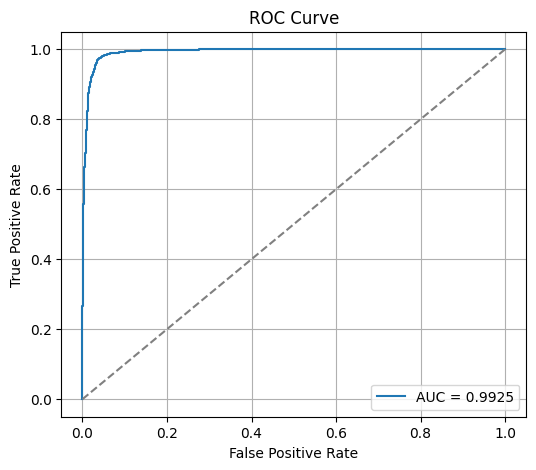

In [23]:
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_probs):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

We now plot the precision/recall curve

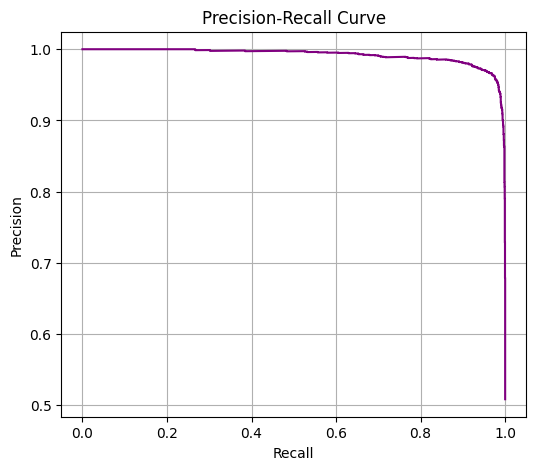

In [24]:
precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

#### Confusion matrix

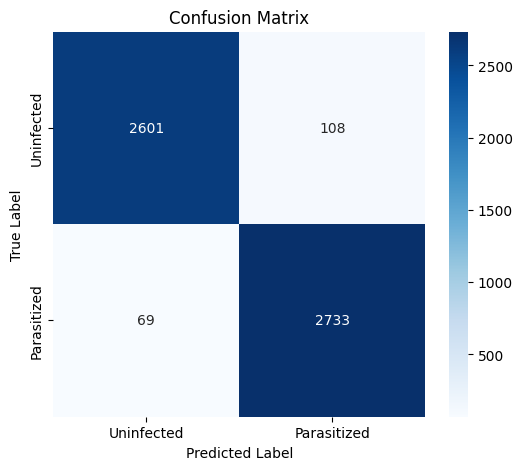

In [25]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()